
# Assignment: Linear Regression, Logistic Regression, and K-Means (From Scratch)

**Instructions**
- You are NOT allowed to use `scikit-learn` for model implementation, scaling.
- You may use it for implementation of clustering
- You may use: `numpy`, `matplotlib`, and standard Python libraries only.
- Every step (scaling, loss, gradients, optimization) must be implemented manually.
- Clearly comment your code and explain your reasoning in Markdown cells.


## Question 1: Linear Regression from Scratch (with Standardization and Regularization)

You are given a dataset `(X, y)`.

### Tasks
1. Implement **StandardScaler manually**:
   - Compute mean and standard deviation for each feature.
   - Standardize the features.
2. Implement **Linear Regression using Gradient Descent**.
3. Add **L2 Regularization (Ridge Regression)**.
4. Plot:
   - Loss vs iterations
   - True vs predicted values

Do NOT use `sklearn`.


In [67]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# Implement StandardScaler manually ,  first read about it, how it works and then implement it
class StdScaler:
  # 1 column=1 feature, store mean and std deviation of each feature
    def __init__(self):
        self.mu = None
        self.sigma = None

    def fit(self, data):
        data = data.astype(np.float64)
        n_s = data.shape[0]
      # find mean
        mu_temp = np.sum(data, axis=0, keepdims=True) # (1,n_columns)
        mu_temp /= n_s
      # find std deviation
        sigma_temp = np.sum((data - mu_temp)**2, axis=0, keepdims=True)
        sigma_temp /= n_s
        sigma_temp = np.sqrt(sigma_temp) # (1,n_columns)
        sigma_temp[sigma_temp == 0] = 1 # avoid divide by 0 in normalization
      # assign back
        self.mu = mu_temp
        self.sigma = sigma_temp

    def transform(self, data):
        data_scaled = (data - self.mu) / self.sigma
        return data_scaled

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [69]:
# Implement Linear Regression from scratch, here you have to also construct the regulization term coefficient of which will be
# denoted by l2_lambda
# try to implement L1 regularization or atlease read about it and where it is used
class LinReg:
    def __init__(self, lr=0.01, epochs=1000, lambda_l2=0.0):
        self.lr = lr
        self.epochs = epochs
        self.lambda_l2 = lambda_l2
        # model parameters
        self.w = None
        self.b = None

        self.losses = []


    def fit(self, X, y):
        X = X.astype(float)
        y = y.astype(float)

        n_s = X.shape[0]           # total records
        n_f = X.shape[1]
        n_out = y.shape[1]   # no. of output columns

        # initialize with random values for gradient descent steps
        w = np.random.randn(n_f, n_out) * 0.01  # (n_features, n_outputs)
        b = np.zeros((1, n_out))                        # (1, n_outputs)

        # using batch gradient descent
        # use whole batch in one iteration
        for _ in range(0, self.epochs):
            residuals = X @ w + b - y   # residual (N, n_outputs)

            # gradients
            grad_w = (2/n_s) * (X.T @ residuals) + 2 * self.lambda_l2 * w
            grad_b = (2/n_s) * np.sum(residuals, axis=0, keepdims=True)

            # update
            w -= self.lr * grad_w
            b -= self.lr * grad_b

            # store losses
            current_loss = np.mean((residuals)**2) + self.lambda_l2 * np.sum(w**2)
            self.losses.append(current_loss)

        # assign back
        self.w = w
        self.b = b

    def predict(self, X):
        return X @ self.w + self.b   # (N, n_outputs)

Learned w: [ 2.89780487 -1.90249448]
Learned b: [[1.39868921]]


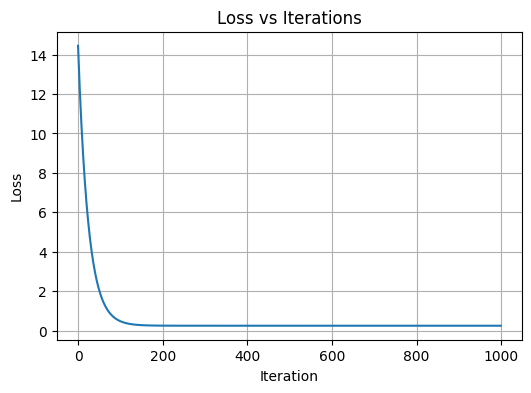

In [70]:
# Test on data
np.random.seed(42)

n_s = 200          # number of samples
n_f = 2            # number of features

# features
X = np.random.randn(n_s, n_f)

# true parameters
w_true = np.array([[3.0], [-2.0]])
b_true = 1.5

# targets with noise
y = X @ w_true + b_true + 0.5 * np.random.randn(n_s, 1)

# scale
scaler = StdScaler()
X_scaled = scaler.fit_transform(X)

# make model
lr_model = LinReg() # defualt hyperparameters
lr_model.fit(X_scaled, y)

print("Learned w:", lr_model.w.ravel())
print("Learned b:", lr_model.b)

# Plot
plt.figure(figsize=(6,4))
plt.plot(lr_model.losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.grid(True)
plt.show()

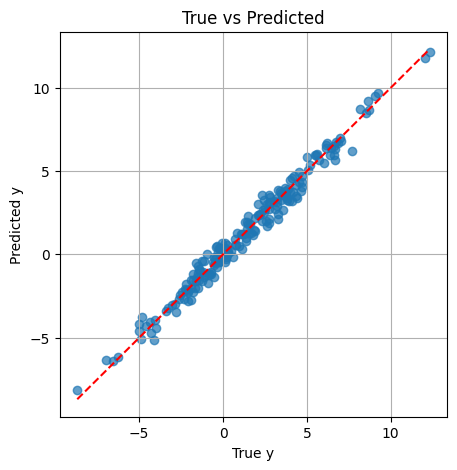

In [71]:
# compare predictions with ground truth
y_pred = lr_model.predict(X_scaled)
plt.figure(figsize=(5,5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect line
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("True vs Predicted")
plt.grid(True)
plt.show()


## Question 2: Logistic Regression from Scratch (with Standardization and Regularization)

You are given a binary classification dataset.

### Tasks
1. Reuse your **manual StandardScaler**.
2. Implement **Logistic Regression using Gradient Descent**.
3. Use:
   - Sigmoid function
   - Binary Cross Entropy loss
4. Add **L2 Regularization**.
5. Report:
   - Training loss curve
   - Final accuracy

Do NOT use `sklearn`.


In [72]:

def sigmoid(val):
    # handle +ve and -ve cases seperately for numerical stability
    result = np.empty_like(val, dtype=np.float32)

    pos_idx = val >= 0
    neg_idx = ~pos_idx

    result[pos_idx] = 1 / (1 + np.exp(-val[pos_idx]))
    exp_neg_val = np.exp(val[neg_idx])
    result[neg_idx] = exp_neg_val / (1 + exp_neg_val)

    return result


In [73]:

#Implement Logistic Regression from scratch and here also add the regularizaation term
class LogReg:
    def __init__(self, lr=0.01, epochs=1000, lambda_l2=0.0):
        self.lr = lr
        self.epochs = epochs
        self.lambda_l2 = lambda_l2
        # model parameters
        self.w = None
        self.b = None

        self.losses = []

    def fit(self, X, y_true):
        X = X.astype(float)
        y_true = y_true.astype(float)

        n_s = X.shape[0]           # total records
        n_f = X.shape[1]
        n_out = y_true.shape[1]   # no. of output columns(=1 for binary classification)

        # initialize with random values for gradient descent steps
        w = np.random.randn(n_f, n_out) * 0.01  # (n_features, n_outputs)
        b = np.zeros((1, n_out))                        # (1, n_outputs)

        # using batch gradient descent
        # use whole batch in one iteration
        for _ in range(0, self.epochs):
            probs = sigmoid(X @ w + b)          # predicted probabilities
            errors = probs - y_true                       # residual (N, n_outputs)

            # gradients
            grad_w = (1/n_s) * (X.T @ errors) + 2 * self.lambda_l2 * w
            grad_b = (1/n_s) * np.sum(errors, axis=0, keepdims=True)

            # update
            w -= self.lr * grad_w
            b -= self.lr * grad_b

            # store losses (binary cross-entropy + L2)
            current_loss = -np.mean(
                y_true * np.log(probs + 1e-15) + (1 - y_true) * np.log(1 - probs + 1e-15)
            ) + self.lambda_l2 * np.sum(w**2)

            self.losses.append(current_loss)

        # assign back
        self.w = w
        self.b = b

    def predict_proba(self, X):
        return sigmoid(X @ self.w + self.b)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs >= 0.5).astype(int)   # threshold->class labels

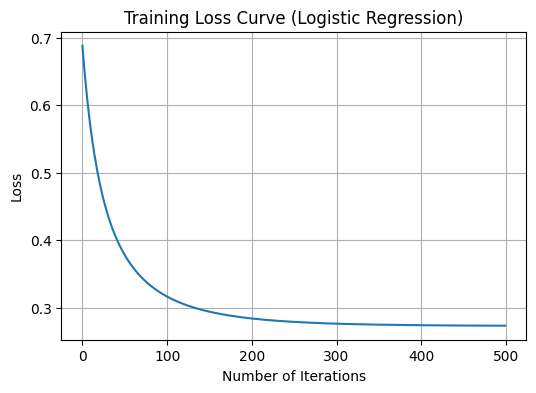

Final training accuracy: 0.99


In [74]:
# Test on sample data
np.random.seed(42)

# number of samples
n_s = 300

# two features
X = np.random.randn(n_s, 2)

# true parameters (unknown to model)
w_true = np.array([[2.0], [-3.0]])
b_true = 0.5

# linear scores
lin_scores = X @ w_true + b_true

# probabilities
probs = 1 / (1 + np.exp(-lin_scores))

# binary labels
y_true = (probs >= 0.5).astype(int)   # shape (N,1)

# scale
scaler = StdScaler()
X_scaled = scaler.fit_transform(X)

# train
logr_model = LogReg(
    lr=0.1,
    epochs=500,
    lambda_l2=0.01
)

logr_model.fit(X_scaled, y_true)

# Plot training loss curve
plt.figure(figsize=(6,4))
plt.plot(logr_model.losses)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Logistic Regression)")
plt.grid(True)
plt.show()

# Report final accuracy
y_pred_class = logr_model.predict(X_scaled)
train_accuracy = np.mean(y_pred_class == y_true)
print("Final training accuracy:", train_accuracy)

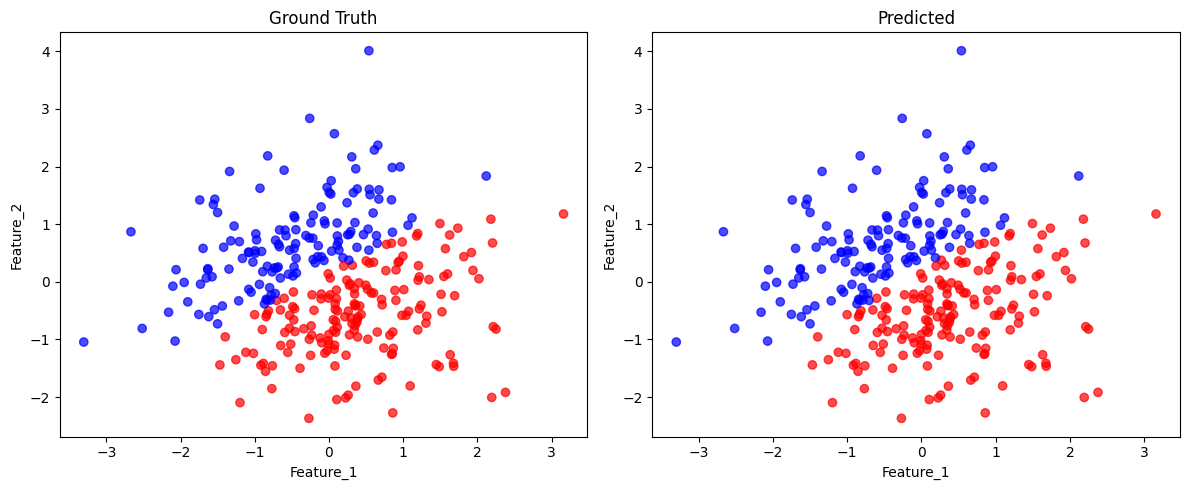

In [75]:
# Plot predicted data vs actual data for visual comparison
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(
    X_scaled[:,0],
    X_scaled[:,1],
    c=y_true.flatten(),
    cmap="bwr",
    alpha=0.7
)
axs[0].set_title("Ground Truth")
axs[0].set_xlabel("Feature_1")
axs[0].set_ylabel("Feature_2")

axs[1].scatter(
    X_scaled[:,0],
    X_scaled[:,1],
    c=y_pred_class.flatten(),
    cmap="bwr",
    alpha=0.7
)
axs[1].set_title("Predicted")
axs[1].set_xlabel("Feature_1")
axs[1].set_ylabel("Feature_2")

plt.tight_layout()
plt.show()


## Question 3: K-Means Clustering from Scratch (Matrix Clustering)

You are given a **random matrix** `M` of shape `(n, m)`.

### Tasks
Implement K-Means clustering **from scratch** such that:

1. Input:
   - A random matrix `M`
   - Number of clusters `k`
2. Output:
   - `assignment_table`: a matrix of same shape as `M`, where each element stores the **cluster label**
   - `cookbook`: a dictionary (hashmap) where:
     - Key = cluster index
     - Value = list of **positions (i, j)** belonging to that cluster
   - `centroids`: array storing centroid values

You must cluster **individual elements**, not rows.


In [76]:

# Implement K-Means for matrix elements
#CAN USE SK-LEARN FOR THIS TASK AS THIS TASK WILL HELP US DIRECTLY IN OUR PROJECT !
from sklearn.cluster import KMeans
def kmeans_matrix(mat, k, max_iterations=100):
    '''
    Returns:
    assign_tbl: same shape as M, contains cluster labels
    cluster_map: dict -> cluster_id : list of (i, j) positions
    centroids_vals: numpy array of centroid values
    '''
    rows, cols = mat.shape
    # flatten to (m*n,1)
    flat_data = mat.reshape(-1,1)

    # run kmeans
    kmeans_model = KMeans(
        n_clusters=k, # k clusters
        init="k-means++", # smart init
        n_init=10, # run 10 times
        max_iter=300,
        random_state=42
    )
    kmeans_model.fit(flat_data)

    # get labels and centroids
    cluster_labels = kmeans_model.labels_ # (m*n,1)
    centroids_vals = kmeans_model.cluster_centers_.flatten() # (k,1)

    assign_tbl = cluster_labels.reshape(rows, cols) # rollback to matrix form
     # cluster_map
    cluster_map = {idx:[] for idx in range(k)}
    for i in range(rows):
      for j in range(cols):
        c_id = assign_tbl[i,j]
        cluster_map[c_id].append((i,j))
    return assign_tbl, cluster_map, centroids_vals

In [77]:
# example usage
input_mat = np.array([
    [10, 12, 11],
    [200, 210, 190],
    [50, 55, 53]
])
k = 3
assign_tbl, cluster_map, centroids_vals = kmeans_matrix(input_mat, k)
print("Assignment table:\n", assign_tbl)
print("\nCentroids:\n", centroids_vals)
print("\nCookbook:")
for key, pos_list in cluster_map.items():
    print(f"Cluster {key}: {pos_list}")

Assignment table:
 [[2 2 2]
 [0 0 0]
 [1 1 1]]

Centroids:
 [200.          52.66666667  11.        ]

Cookbook:
Cluster 0: [(1, 0), (1, 1), (1, 2)]
Cluster 1: [(2, 0), (2, 1), (2, 2)]
Cluster 2: [(0, 0), (0, 1), (0, 2)]



## Submission Guidelines
- Submit the completed `.ipynb` file.
- Clearly label all plots and outputs.
- Code readability and correctness matter.
- Partial credit will be given for logically correct implementations.

**Bonus**
- Compare convergence with and without standardization.
- Try different values of regularization strength.
